
# Train Passt-tiny on CREMA-D dataset

---

[![GitHub](https://badges.aleen42.com/src/github.svg)](https://github.com/ultralytics/ultralytics)



## Setup

In [1]:
#!/usr/bin/env python
# Finetune PaSST for emotion recognition (GPU‑friendly, silent)
# ------------------------------------------------------------
# Notebook‑ready: each section is a cell (# %%).
# Uses **torch.amp** API (PyTorch 2.x) with amp.GradScaler and torch.amp.autocast("cuda").

# %% [markdown]
# ### 0  Setup & installs (skip if already satisfied)
# !pip install hear21passt torchaudio scikit-learn tqdm matplotlib seaborn --quiet

# %%
import os, random, csv
from pathlib import Path
from typing import List, Tuple

import torch, torchaudio, soundfile as sf
import torch.nn as nn
import torch.nn.functional as F
import torchaudio.transforms as T
from torch.utils.data import Dataset, DataLoader

# mixed precision
from torch import amp                 # torch.amp API (PyTorch ≥ 2.0)
from torch.amp import autocast         # amp.autocast("cuda") is the new form

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from tqdm.auto import tqdm

from hear21passt.base import get_model_passt
import hear21passt.models.passt as passt_module
passt_module.first_RUN = False  # silence debug prints

torch.backends.cudnn.benchmark = True

/home/lucky/anaconda3/envs/ee526/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


**NOTE:** To make it easier for us to manage datasets, images and models we create a `HOME` constant.

## Install PaSST transformer

In [2]:
# %% [markdown]
# ### 1  Seed
# %%

def set_seed(seed=42):
    random.seed(seed); np.random.seed(seed)
    torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
set_seed()

# %% [markdown]
# ### 2  Constants
# %%
EMOTIONS = ["ANG", "DIS", "FEA", "HAP", "NEU", "SAD"]
LABEL_MAP = {e: i for i, e in enumerate(EMOTIONS)}
TARGET_SR = 32_000
NUM_SAMPLES = 1024 + (998 - 1) * 320  # 10 s @ 32 kHz
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using", DEVICE)


Using cuda


## Preprocess and extract embeddings




In [3]:
# %% [markdown]
# ### 3  Dataset → log‑mel (1×128×998)
# %%
class EmotionDataset(Dataset):
    def __init__(self, csv_path: Path, audio_root: Path, augment=False):
        self.recs: List[Tuple[Path, int]] = []
        with open(csv_path, newline="") as f:
            for row in csv.DictReader(f):
                emo = row["emotion"].strip().upper(); fn = row["filename"].strip()
                if emo in LABEL_MAP:
                    self.recs.append((audio_root / fn, LABEL_MAP[emo]))
        if not self.recs:
            raise ValueError("CSV has no usable rows")
        self.augment = augment
        self.resample = T.Resample(TARGET_SR, TARGET_SR)
        self.mel = T.MelSpectrogram(sample_rate=TARGET_SR, n_fft=1024, hop_length=320, n_mels=128, center=False)
        self.db = T.AmplitudeToDB("power")
        self.pitch = lambda w: T.PitchShift(TARGET_SR, n_steps=random.uniform(-2, 2))(w)
        self.gain = lambda w: T.Vol(gain=random.uniform(-6, 6), gain_type="db")(w)

    def __len__(self):
        return len(self.recs)

    def _augment(self, wav):
        if random.random() < 0.5:
            wav += torch.randn_like(wav) * 0.005
        if random.random() < 0.3:
            wav = self.gain(wav)
        if random.random() < 0.2:
            wav = self.pitch(wav)
        return wav

    def __getitem__(self, idx):
        path, label = self.recs[idx]
        try:
            wav, sr = torchaudio.load(path)
        except RuntimeError:  # fallback for exotic PCM
            wav_np, sr = sf.read(path, always_2d=False)
            if wav_np.ndim == 1:
                wav_np = wav_np[None, :]
            wav = torch.from_numpy(wav_np).float()
        if wav.shape[0] > 1:
            wav = wav.mean(0, keepdim=True)
        if sr != TARGET_SR:
            wav = self.resample(wav)
        if self.augment:
            wav = self._augment(wav)
        wav = (wav - wav.mean()) / (wav.std() + 1e-9)
        mel = self.db(self.mel(wav)).clamp(min=-80.0)
        mel = F.pad(mel, (0, max(0, 998 - mel.shape[2])))[:, :, :998]
        return mel, label


## Load train/val/test Features

In [4]:

# %% [markdown]
# ### 4  Load data
# %%
DATA_ROOT=Path("/home/lucky/Documents/research/dataset")  # adjust
BATCH = 5; ACC_STEPS = 2
train_ds = EmotionDataset(DATA_ROOT / "train.csv", DATA_ROOT / "train", augment=True)
val_ds   = EmotionDataset(DATA_ROOT / "val.csv",   DATA_ROOT / "val")
test_ds  = EmotionDataset(DATA_ROOT / "test.csv",  DATA_ROOT / "test")
collate = lambda b: (torch.stack([x for x, _ in b]), torch.tensor([y for _, y in b]))
train_loader = DataLoader(train_ds, BATCH, True, drop_last=True, pin_memory=True, collate_fn=collate)
val_loader   = DataLoader(val_ds,   BATCH, False, pin_memory=True, collate_fn=collate)
print(len(train_ds), "train", len(val_ds), "val", len(test_ds), "test")

# %% [markdown]
# ### 5  Model & training utilities
# %%
model = get_model_passt("passt_s_swa_p16_128_ap476", pretrained=True, n_classes=len(EMOTIONS)).to(DEVICE)
for n, p in model.named_parameters():
    p.requires_grad = n.startswith("blocks.11") or n.startswith("mlp_head")
print("Trainable", sum(p.numel() for p in model.parameters() if p.requires_grad) / 1e6, "M params")

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-5, weight_decay=1e-2)
scaler = amp.GradScaler(device="cuda")

# patchout for memory
model.train_patchout = True; model.train_patchout_t = 5; model.train_patchout_f = 2

# %% [markdown]
# ### 6  Train / eval loops (AMP + accumulation)
# %%

5209 train 1116 val 1117 test


 Loading PASST TRAINED ON AUDISET 


PaSST(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(1, 768, kernel_size=(16, 16), stride=(10, 10))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (drop_path): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=3072, out_features=768, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
    )
    (1): Block(
     

In [5]:
## Create DataLoaders

In [6]:
def one_epoch():
    model.train(); running = 0; optimizer.zero_grad()
    for i, (xb, yb) in enumerate(tqdm(train_loader, desc="train", leave=False)):
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        with autocast(device_type="cuda"):
            out = model(xb)[0] if isinstance(model(xb), tuple) else model(xb)
            loss = criterion(out, yb) / ACC_STEPS
        scaler.scale(loss).backward()
        if (i + 1) % ACC_STEPS == 0:
            scaler.step(optimizer); scaler.update(); optimizer.zero_grad()
        running += loss.item() * ACC_STEPS * xb.size(0)
    return running / len(train_loader.dataset)


def evaluate(loader):
    model.eval(); yt, yp = [], []
    with torch.no_grad(), autocast(device_type="cuda"):
        for xb, yb in loader:
            logits = model(xb.to(DEVICE))
            logits = logits[0] if isinstance(logits, tuple) else logits
            preds = logits.argmax(1).cpu()
            yt += yb.tolist(); yp += preds.tolist()
    return f1_score(yt, yp, average="weighted"), yt, yp


In [7]:
## Define MLP Classifier

In [8]:
# %% [markdown]
# ### 7  Run training
# %%
EPOCHS = 20; best = 0
for ep in range(1, EPOCHS + 1):
    tloss = one_epoch()
    f1, _, _ = evaluate(val_loader)
    print(f"Epoch {ep:02d}: loss {tloss:.4f}  val‑F1 {f1:.4f}")
    if f1 > best:
        torch.save(model.state_dict(), "best_passt_emotion.pt"); best = f1; print("📝 new best saved")


Epoch 01: loss 1.6578  val‑F1 0.3281
📝 new best saved


Epoch 02: loss 1.4826  val‑F1 0.3884
📝 new best saved


Epoch 03: loss 1.4142  val‑F1 0.3793


Epoch 04: loss 1.3883  val‑F1 0.4044
📝 new best saved


Epoch 05: loss 1.3587  val‑F1 0.4467
📝 new best saved


Epoch 06: loss 1.3399  val‑F1 0.4462


Epoch 07: loss 1.3206  val‑F1 0.4445


Epoch 08: loss 1.3025  val‑F1 0.4740
📝 new best saved


Epoch 09: loss 1.2855  val‑F1 0.4604


Epoch 10: loss 1.2627  val‑F1 0.4832
📝 new best saved


Epoch 11: loss 1.2494  val‑F1 0.4667


Epoch 12: loss 1.2316  val‑F1 0.4649


Epoch 13: loss 1.2232  val‑F1 0.4717


Epoch 14: loss 1.2098  val‑F1 0.4889
📝 new best saved


Epoch 15: loss 1.1995  val‑F1 0.4755


Epoch 16: loss 1.1809  val‑F1 0.4676


Epoch 17: loss 1.1794  val‑F1 0.4791


Epoch 18: loss 1.1557  val‑F1 0.4873


Epoch 19: loss 1.1451  val‑F1 0.4999
📝 new best saved


Epoch 20: loss 1.1374  val‑F1 0.5119
📝 new best saved


In [9]:
## Training Parameters

Test F1 0.5207430970083063
              precision    recall  f1-score   support

         ANG     0.7158    0.6859    0.7005       191
         DIS     0.3726    0.5131    0.4317       191
         FEA     0.5058    0.4579    0.4807       190
         HAP     0.5372    0.5288    0.5330       191
         NEU     0.5111    0.4233    0.4631       163
         SAD     0.5284    0.4869    0.5068       191

    accuracy                         0.5184      1117
   macro avg     0.5285    0.5160    0.5193      1117
weighted avg     0.5290    0.5184    0.5207      1117



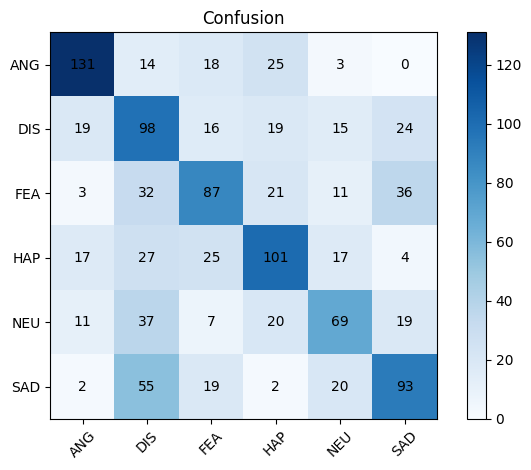

In [10]:
# %% [markdown]
# ### 8  Test metrics
# %%
model.load_state_dict(torch.load("best_passt_emotion.pt",map_location=DEVICE))
f1,y_true,y_pred=evaluate(DataLoader(test_ds,batch_size=BATCH,collate_fn=collate))
print("Test F1",f1); print(classification_report(y_true,y_pred,target_names=EMOTIONS,digits=4))
cm=confusion_matrix(y_true,y_pred)
plt.imshow(cm,cmap="Blues");plt.title("Confusion");plt.colorbar();plt.xticks(range(6),EMOTIONS,rotation=45);plt.yticks(range(6),EMOTIONS)
for i in range(6):
    for j in range(6):
        plt.text(j,i,cm[i,j],ha="center",va="center")
plt.tight_layout(); plt.show()


In [11]:
## Training Loop

In [12]:
## Evaluation